# Using the real time SQL monitoring

- Status
- Duration


# Using Realtime SQL Monitoring

- Oracle Enterprice Manager

# Using the trace files & TKPROF

- Performance information of our queries
- CPU Time and Elapsed Time
- Wait Events
- Execution plans
- Row Counts
- Call Counts (parse, execute, fetch)
- Physical and Logical reads

```sql
SELECT value FROM V$DIAG\_INFO WHERE name = 'Diag Trace';
``` 

- How to enable / disable tracing?
    - dbms\_monitor.database\_monitor()

- How to track our own session?
    ```sql 
    ALTER SESSION SET SQL_TRACE = TRUE|FALSE;
    ```
    - 

```sql
sqlplus / as sysdba;
 
alter session set tracefile_identifier= TUN;
 
alter session set sql_trace = true;
 
select * from hr.employees;
 
alter session set sql_trace = false;
 
select value from v$diag_info where name = ‘Diag Trace’;
 
cd c:\app\omr\diag\rdbms\orcl\orcl\trace
 
tkprof file_name.trc tun_ex.txt
``` 

# Get what you need only

- Do not use select * from all the queries
    - the optimizer may select a worse plan if you query for unnecessary columns
    - While joining multiple tables or querying from views, selecting less columns might affect the performance
    - If you use select \*, the database needs to check the data dictionary to get the table structure
    - select \* will make the databse perform more I/O operations
    - 

# Index Usage

- How do I make the optimizer use my indexes?
    - If the selectivity of the predicate is high, using indexes may increase the performance of the query very much
    - Add adequate predicates to the queries (Use indexed columns in your queries clearly)
    - Use reasonable hints in your queries

# Using Concatenation Operator

```sql
select first_name, last_name, employee_id, salary from employees 
where first_name||last_name = 'StevenKING';
 
select first_name, last_name, employee_id, salary from employees 
where first_name = 'Steven' and last_name = 'KING';
``` 

# Using Arithmetic Operator

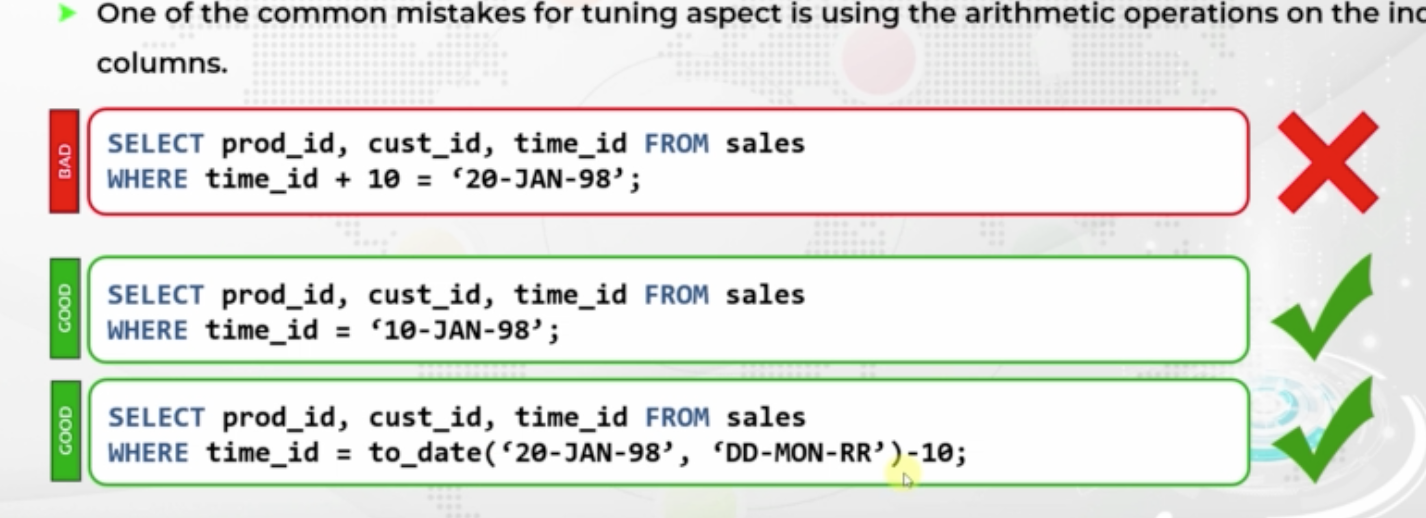

# Using Like Operator

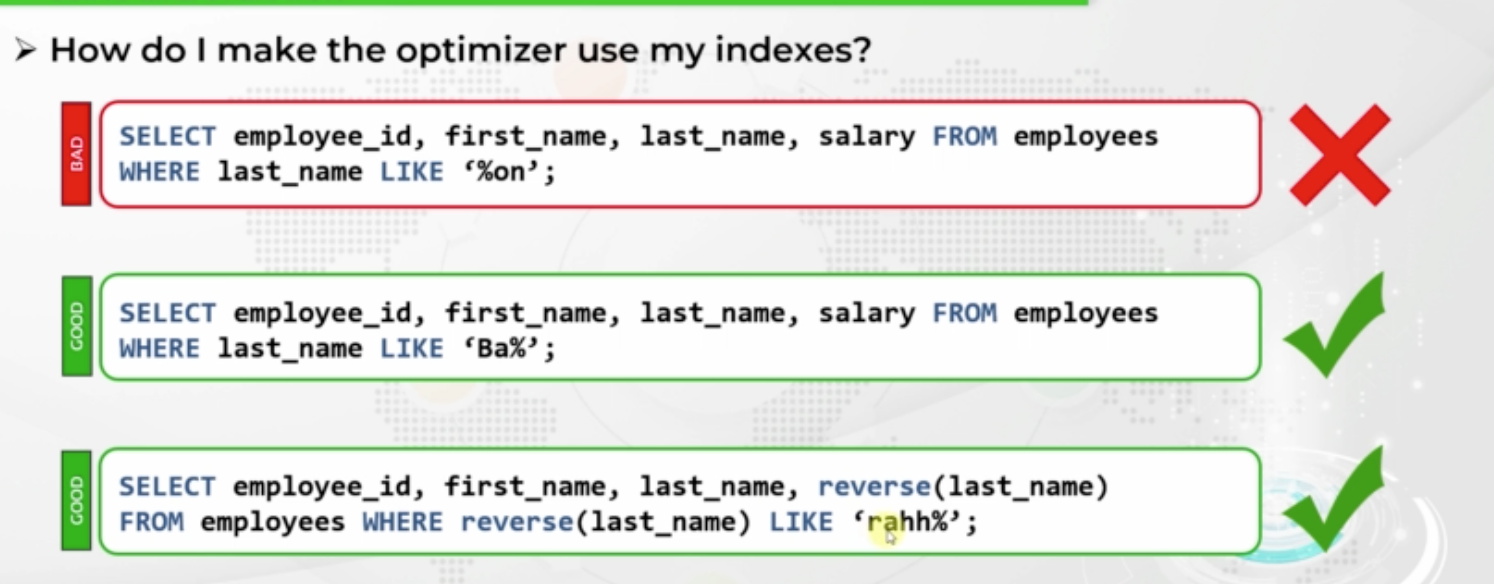

```sql
select employee_id, first_name, last_name, salary from employees
where last_name like '%on';
 
select employee_id, first_name, last_name, salary from employees
where last_name like '%on%';
 
select employee_id, first_name, last_name, salary from employees
where last_name like 'Ba%';
 
create index last_name_reverse_index on employees(REVERSE(last_name));
 
select employee_id, first_name, last_name, reverse(last_name), salary
from employees
where reverse(last_name) like 'rahh%';
 
drop index last_name_reverse_index;
``` 

# Using functions on columns

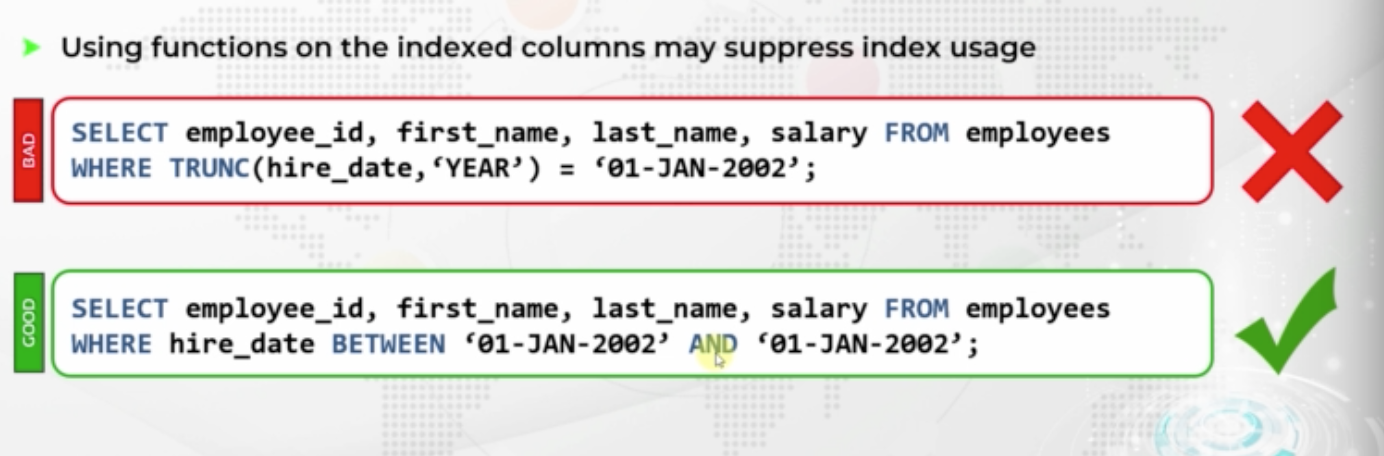

```sql
create index emp_date_temp_idx on employees (hire_date) compute statistics;
 
select employee_id, first_name, last_name
from employees where trunc(hire_date,'YEAR') = '01-JAN-2002';
 
select employee_id, first_name, last_name
from employees where hire_date between '01-JAN-2002' and '31-DEC-2002';
 
drop index emp_date_temp_idx;
 
select prod_id,prod_category,prod_subcategory from products
where substr(prod_subcategory,1,2) = 'Po';
 
select prod_id,prod_category,prod_subcategory from products
where prod_subcategory like 'Po%';
``` 

# Handling IS NULL & IS NOT NULL Efficiency

- How do I make the optimizer use my indexes?
    - B-Tree indexes do not index the null values and this sometimes may suppress the index usage in our queries
    - Ways to handle null value based performance loss
        - Use IS NOT NULL condition in your where clause if you don't need to have the null values in the result set
        - Add not null constraint to your columns and insert a specific value for the null values
        - If reasonable, create a BITMAP index instead of a B-TREE index 

```sql
CREATE TABLE employees_temp AS SELECT * FROM employees;
 
CREATE INDEX comm_pct_idx ON employees_temp(commission_pct) COMPUTE STATISTICS;
 
SELECT * FROM employees_temp WHERE commission_pct <> 1;
 
SELECT * FROM employees_temp WHERE commission_pct <> 1 AND commission_pct IS NOT NULL;
 
SELECT employee_id,commission_pct FROM employees_temp WHERE commission_pct IS NULL;
 
SELECT /*+ index(employees_temp comm_pct_idx)*/employee_id,commission_pct 
FROM employees_temp WHERE commission_pct IS NULL;
 
UPDATE employees_temp SET commission_pct = 0 WHERE commission_pct IS NULL;
COMMIT;
 
SELECT employee_id,commission_pct FROM employees_temp WHERE commission_pct = 0;
 
UPDATE employees_temp SET commission_pct = NULL WHERE commission_pct = 0;
COMMIT;
 
DROP INDEX comm_pct_idx;
CREATE BITMAP INDEX comm_pct_idx ON employees_temp(commission_pct) COMPUTE STATISTICS;
 
SELECT employee_id,commission_pct FROM employees_temp WHERE commission_pct IS NULL;
 
SELECT /*+ index(employees_temp comm_pct_idx)*/employee_id,commission_pct 
FROM employees_temp WHERE commission_pct IS NULL;
 
DROP TABLE employees_temp;
``` 

# Things to know for in - exists and not in exists

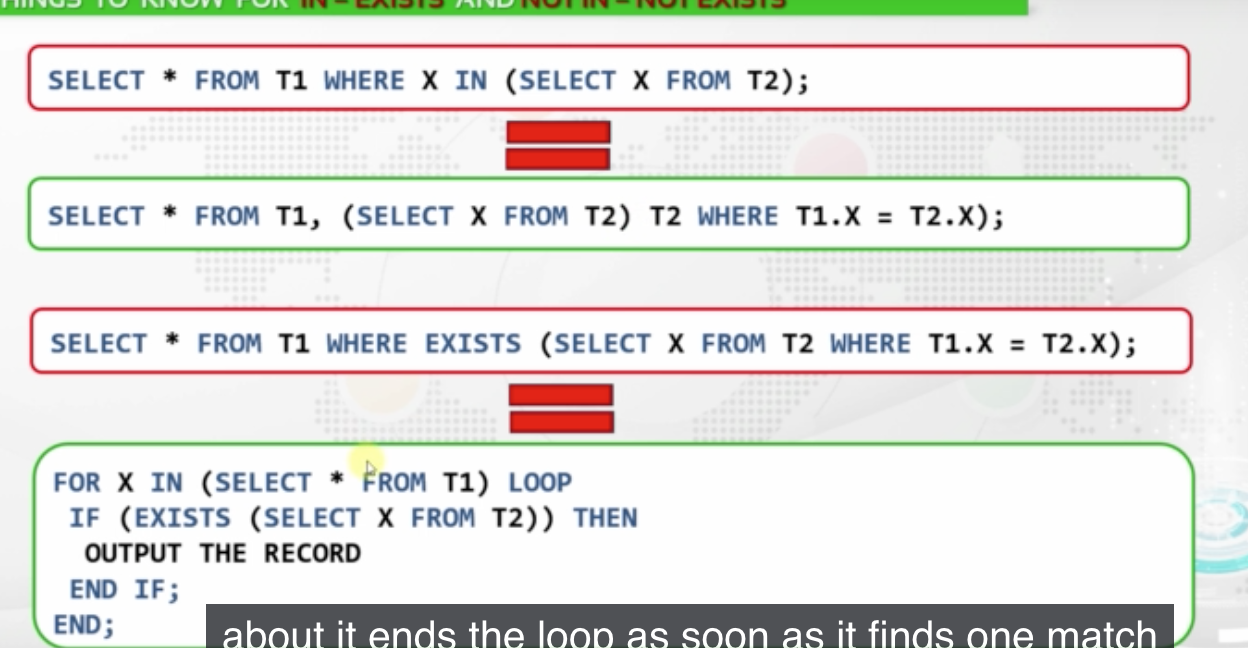

# Using Trucate instead of DELETE

- Truncate is always faster than the DELETE command (Truncate doesn't generate UNDO data, but delete generates)
- Things to know about truncate
    - Truncate operation cannot be rollbacked. Falshback is also not so easy after truncate operations
    - truncate is a DDL operation. So it performs commits before and after the truncate operation
    - We can truncate a single partition as well
    - Truncate doesn't fire the DML triggers. But it can fire the DDL triggers
    - Truncate makes unusable indexes usable again. But delete does not.

 ```sql
 create table sales_temp1 as select * from sales;
create table sales_temp2 as select * from sales;
 
delete from sales_temp1;
 
truncate table sales_temp2;
 
drop table sales_temp1;
drop table sales_temp2;
``` 

# Data Type Mismatch

- If the data types of the column and compared value don't match, this may suppress the index usage

```sql
SELECT cust_id, cust_first_name, cust_last_name FROM customers WHERE cust_id = 3228;
 
SELECT cust_id, cust_first_name, cust_last_name FROM customers WHERE cust_id = '3228';
 
CREATE INDEX cust_postal_code_idx ON customers (cust_postal_code);
 
SELECT cust_id, cust_first_name, cust_last_name FROM customers WHERE cust_postal_code = 60332;
 
SELECT cust_id, cust_first_name, cust_last_name FROM customers WHERE cust_postal_code = '60332';
 
SELECT cust_id, cust_first_name, cust_last_name FROM customers WHERE to_number(cust_postal_code) = 60332;
 
DROP INDEX cust_postal_code_idx;
``` 

# Tuning Ordered Queries

- order by mostly requires sort operations
- The sort operations are done in PGA or discs
- How to tune the order by clauses?
    - Create or modify B-Tree indexes including the column used in the order by clause
    - Increase the PGA size
    - Query for only the indexes colums in the select clause
    - Restrict the returning rows

```sql
select prod_id,cust_id,time_id from sales order by amount_sold;
select prod_id,cust_id,time_id from sales order by cust_id;
select prod_id,cust_id,time_id from sales where cust_id < 100 order by cust_id;
select cust_id from sales order by cust_id;
select cust_id from customers order by cust_id;
select cust_id,cust_first_name, cust_last_name from customers where cust_id < 100 order by cust_id;
select cust_id, cust_first_name, cust_last_name from customers order by cust_first_name;
``` 

# Retrieving Min & Max values

- B-Tree indexes increase the performance a lot for the min & max value searches
- To find the min or max value, it needs to read the whole table
- In B-Tree indexes, the rightmost and left most leaves have the maximum and minimum value of the indexed column
- If the returning rows are restricted, this time instead of leftmost and rightmost leaves, some other leaves have the min and max values. But again, it doesn't need to read all the rows of the index
- If the query has multiple agggregate functions or another column, it will perform index full scan or table access full

```sql
select max(CUST_STREET_ADDRESS) from customers;
select max(cust_year_of_birth) from customers;
select cust_year_of_birth from customers;
select max(cust_id) from customers;
select cust_id from customers;
select cust_id from customers where cust_id < 1000;
select max(cust_id) from customers where cust_id < 1000;
select min(cust_id) from customers;
select min(cust_id), max(cust_id) from customers;
SELECT MAX(cust_id), MAX(cust_id) FROM customers;
select * from
 (select min(cust_id) min_cust from customers) min_customer,
 (select max(cust_id) max_cust from customers) max_customer;
```

# Union & Union All

- Union use sort

# Avoid using Having Clause

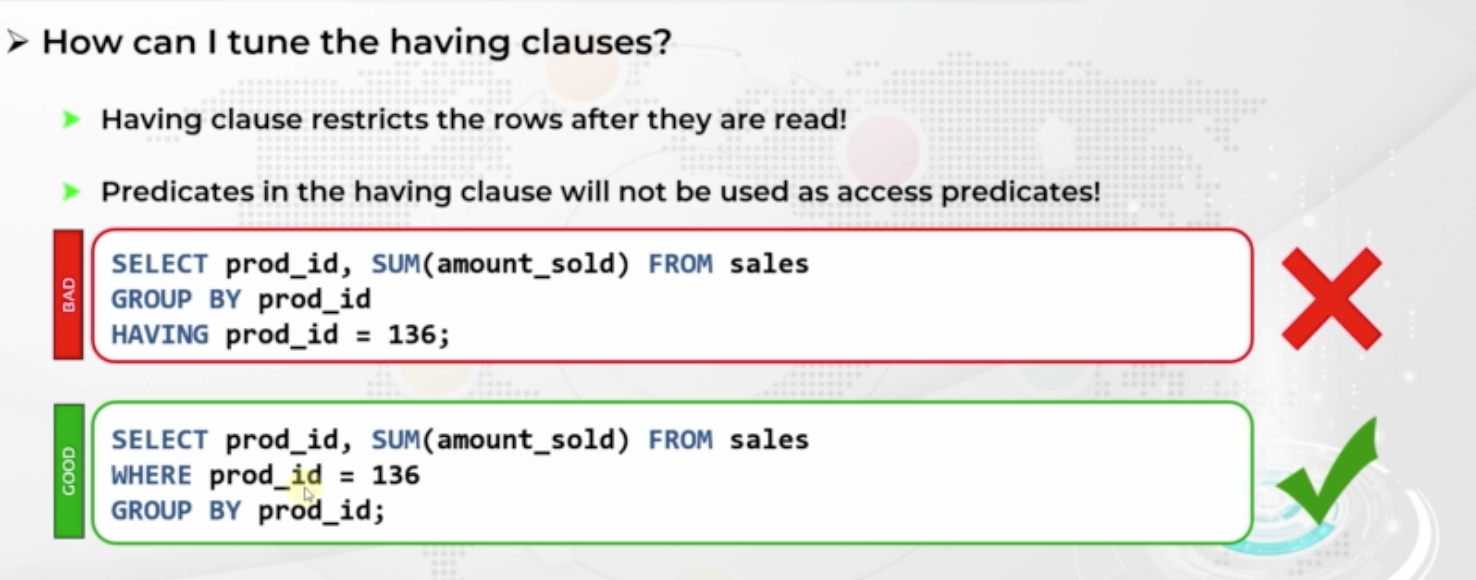

```sql
select time_id,sum(amount_sold) from sales
group by time_id
having time_id between '01-JAN-01' and '28-FEB-01';
 
select time_id,sum(amount_sold) from sales
where time_id between '01-JAN-01' and '28-FEB-01'
group by time_id;
 
select prod_id,sum(amount_sold) from sales
group by prod_id
having prod_id = 136;
 
select prod_id,sum(amount_sold) from sales
where prod_id = 136
group by prod_id;
``` 

# Be careful on views

- views on performance aspect
    - do not use the views out of their purposes
- things to be careful on views
    - if you don't need to use all the tables in a view, do not use this view on your queries
    - don't join the complex views with a table or another view
    - avoid performing outer joins to the views
    - be careful oni subquery unnesting 
    - avoid using views inside of a view

```sql
CREATE OR REPLACE VIEW vw_emp_dept AS
SELECT E.employee_id, E.last_name, E.first_name, E.salary, E.job_id,
    D.department_id, D.department_name, D.location_id, L.state_province
    FROM employees E, departments D , locations L
WHERE E.department_id(+) = D.department_id
AND D.location_id = L.location_id;
 
SELECT  V.first_name, V.last_name, j.job_title
FROM jobs j, vw_emp_dept V
WHERE j.job_id = 'IT_PROG'
AND V.job_id = j.job_id;
 
select * from vw_emp_dept;
 
SELECT  E.first_name, E.last_name, j.job_title
FROM employees E, jobs j
WHERE j.job_id = 'IT_PROG'
AND E.job_id = j.job_id;
 
 
CREATE OR REPLACE VIEW vw_cust_num_sold AS
SELECT C.cust_id, cust_first_name,cust_last_name, prod_id, COUNT(*) num_sold FROM sales S, customers C
WHERE S.cust_id = C.cust_id
GROUP BY C.cust_id,cust_first_name, cust_last_name, prod_id
ORDER BY num_sold DESC;
 
SELECT cust_id,prod_name,num_sold
FROM vw_cust_num_sold V, products P
WHERE V.prod_id = P.prod_id
AND V.prod_id = 13;
 
SELECT cust_id,prod_name,num_sold
FROM vw_cust_num_sold V, products P
WHERE V.prod_id = P.prod_id(+)
AND V.prod_id = 13;
 
SELECT C.cust_id, P.prod_name, COUNT(*) num_sold FROM sales S, customers C, products P
WHERE S.cust_id = C.cust_id
AND S.prod_id = P.prod_id(+)
AND P.prod_id = 13
GROUP BY C.cust_id, P.prod_name
ORDER BY num_sold DESC;
 
DROP VIEW hr.vw_emp_dept;
DROP VIEW vw_cust_num_sold;
``` 

# Create Materialized Views

- materialized views store both the query and the data
- The materialized view data can be refreshed manually or by a PL/SQL job, or by auto-refresh DMLs
- Materialized view maintenace also is a burden to the database
- Using materialized views may increase the performance a lot
- We can create indexes, partitions etc, on materialied views

```sql
SELECT C.cust_id, cust_first_name,cust_last_name, prod_id, COUNT(*) num_sold FROM sales S, customers C
WHERE S.cust_id = C.cust_id
GROUP BY C.cust_id,cust_first_name, cust_last_name, prod_id
ORDER BY num_sold DESC;
 
CREATE MATERIALIZED VIEW vw_cust_num_sold
ENABLE QUERY REWRITE AS
SELECT C.cust_id, cust_first_name,cust_last_name, prod_id, COUNT(*) num_sold FROM sales S, customers C
WHERE S.cust_id = C.cust_id
GROUP BY C.cust_id,cust_first_name, cust_last_name, prod_id
ORDER BY num_sold DESC;
 
SELECT * FROM vw_cust_num_sold;
 
SELECT cust_id,prod_name,num_sold
FROM vw_cust_num_sold V, products P
WHERE V.prod_id = P.prod_id
AND V.prod_id = 13;
 
SELECT cust_id,prod_name,num_sold
FROM vw_cust_num_sold V, products P
WHERE V.prod_id = P.prod_id(+)
AND V.prod_id = 13;
 
SELECT C.cust_id, cust_first_name,cust_last_name, prod_id, COUNT(*) num_sold FROM sales S, customers C
WHERE S.cust_id = C.cust_id
AND prod_id = 13
GROUP BY C.cust_id,cust_first_name, cust_last_name, prod_id
ORDER BY num_sold DESC;
 
DROP MATERIALIZED VIEW vw_cust_num_sold;
``` 

# Avoid Commit too much or too less

- For each DML operations, the database creates UNDO data
    - Performing commit frequently will not help on performance
- For each DML oeprations, the database creates REDO data
    - Performing commit frequently will not help on performance 
    - Any changes on the same blocks (which are carried to the redo log file) will be created in redo log buffer again
   
- Updates and deletes will lock the rows and that wiil make the other users wait to perform any other operations on these rows
- How often do we need to commit?
    - As soon as we finish the DML operations
    - For some business-specific reasons

# Partition Pruning

```sql
create table sales_temp as select * from sales;
 
select sum(amount_sold) from sales_temp where time_id between '01-JAN-01' and '31-DEC-03';
 
select sum(amount_sold) from sales where time_id between '01-JAN-01' and '31-DEC-03';
 
drop table sales_temp;
``` 

# Using Bulk Collect

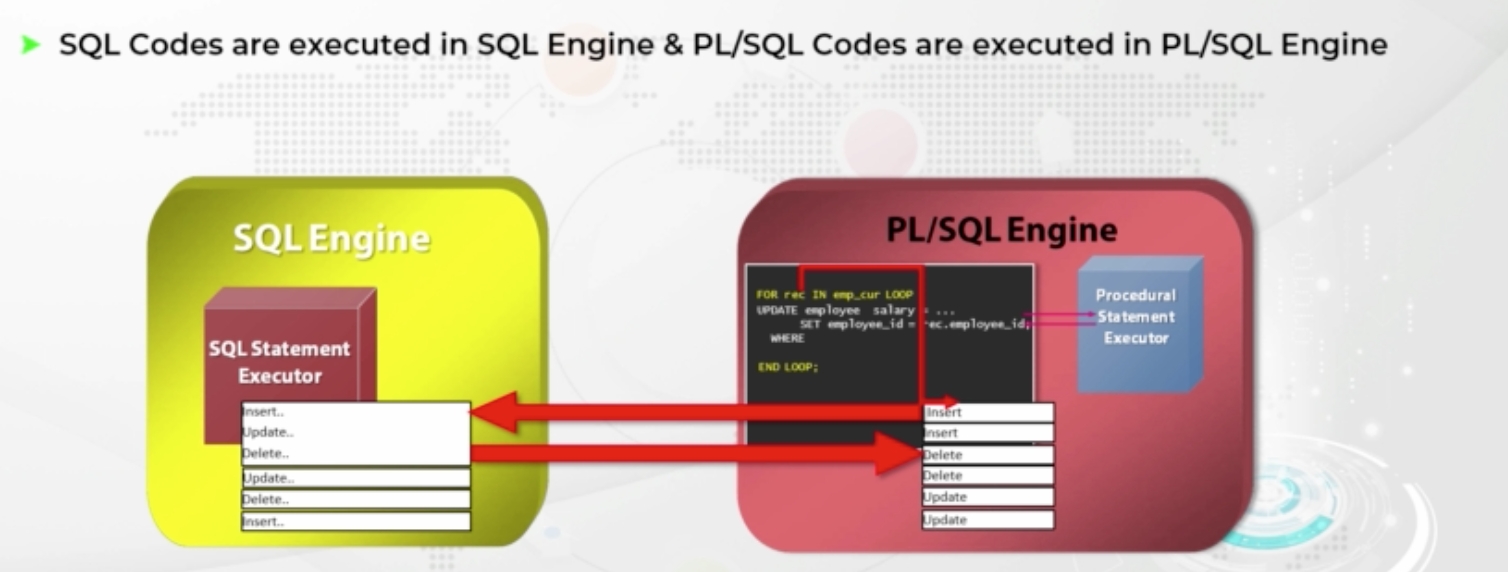

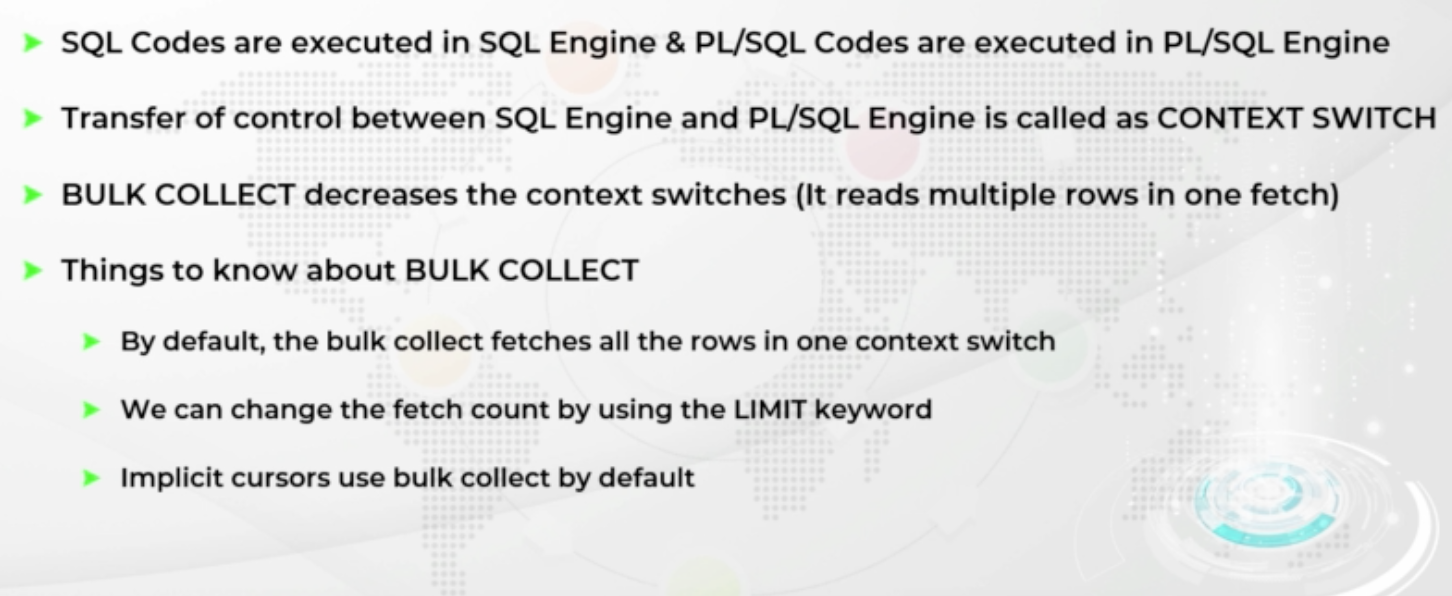

```sql
DECLARE
CURSOR c1 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c1%rowtype;
r1 r_type := r_type();
idx PLS_INTEGER := 0;
BEGIN
OPEN c1;
LOOP
idx:=idx+1;
r1.extend;
FETCH c1 INTO r1(idx);
EXIT WHEN c1%notfound;
END LOOP;
CLOSE c1;
END;
/
 
DECLARE
CURSOR c2 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c2%rowtype;
r1 r_type := r_type();
BEGIN
OPEN c2;
FETCH c2 BULK COLLECT INTO r1;
CLOSE c2;
END;
/
 
DECLARE
CURSOR c3 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c3%rowtype;
r1 r_type := r_type();
BEGIN
OPEN c3;
FETCH c3 BULK COLLECT INTO r1 LIMIT 100;
CLOSE c3;
END;
/
 
DECLARE
CURSOR c4 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c4%rowtype;
r1 r_type := r_type();
BEGIN
OPEN c4;
LOOP
FETCH c4 BULK COLLECT INTO r1 LIMIT 100;
EXIT WHEN c4%notfound;
END LOOP;
CLOSE c4;
END;
/
 
DECLARE
CURSOR c5 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c5%rowtype;
r1 r_type := r_type();
BEGIN
OPEN c5;
LOOP
FETCH c5 BULK COLLECT INTO r1 LIMIT 1000;
EXIT WHEN c5%notfound;
END LOOP;
CLOSE c5;
END;
/
 
DECLARE
CURSOR c6 IS SELECT cust_id, cust_email FROM customers ORDER BY cust_id;
TYPE r_type IS TABLE OF c6%rowtype;
r1 r_type := r_type();
BEGIN
OPEN c6;
LOOP
FETCH c6 BULK COLLECT INTO r1 LIMIT 100000;
EXIT WHEN c6%notfound;
END LOOP;
CLOSE c6;
END;
/
 
DECLARE
TYPE r_type IS TABLE OF varchar2(100) index by pls_integer;
r1 r_type;
BEGIN
FOR r2 IN (SELECT cust_id, cust_email FROM customers ORDER BY cust_id) LOOP
r1(r2.cust_id) := r2.cust_email;
END LOOP;
END;
/
``` 

# Tuning the Join Order

```sql
SELECT /*+ ORDERED */P.prod_name,C.cust_first_name,S.amount_sold FROM  customers C, products P, sales S
WHERE S.cust_id = C.cust_id
AND P.prod_id = S.prod_id;
 
SELECT /*+ ORDERED */P.prod_name,C.cust_first_name,S.amount_sold FROM sales S, customers C, products P
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
 
SELECT /*+ ORDERED */P.prod_name,C.cust_first_name,S.amount_sold FROM sales S, products P , customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
 
SELECT /*+ ORDERED */P.prod_name,C.cust_first_name,S.amount_sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
 
SELECT P.prod_name,C.cust_first_name,S.amount_sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
``` 

# Multitable DML operations

```sql
------------------------ INSERT ALL EXAMPLE -----------------------------
 
CREATE TABLE it_programmers AS SELECT * FROM employees WHERE 1=2;
 
CREATE TABLE sales_representatives AS SELECT * FROM employees WHERE 1=2;
 
INSERT INTO it_programmers SELECT * FROM employees WHERE job_id = 'IT_PROG';
 
INSERT INTO sales_representatives SELECT * FROM employees WHERE job_id = 'SA_REP';
 
INSERT ALL 
    WHEN job_id = 'IT_PROG' THEN INTO it_programmers
    WHEN job_id = 'SA_REP' THEN INTO sales_representatives
SELECT * FROM employees WHERE job_id IN ('IT_PROG','SA_REP');
 
-------------------------- MERGE EXAMPLE --------------------------------
 
CREATE TABLE bonuses (employee_id NUMBER(6,0), bonus NUMBER(8,2), salary NUMBER(8,2), department_id NUMBER(4,0));
 
INSERT INTO bonuses SELECT employee_id, 1000, salary, department_id FROM employees WHERE ROWNUM < 70;
 
INSERT INTO bonuses SELECT employee_id, 1000, salary, department_id FROM employees WHERE department_id = 80 AND salary < 10000
AND employee_id NOT IN (SELECT employee_id FROM bonuses);
 
UPDATE bonuses b SET b.bonus = b.bonus + bonus*0.15 
WHERE employee_id IN (SELECT employee_id FROM employees WHERE department_id = 80 AND salary < 10000);
 
DELETE FROM bonuses WHERE employee_id IN (SELECT employee_id FROM employees WHERE salary >= 10000 OR department_id <> 80);
 
MERGE INTO bonuses b
   USING (SELECT employee_id, salary, department_id FROM employees) E
   ON (b.employee_id = E.employee_id )
   WHEN MATCHED THEN 
     UPDATE SET b.bonus = b.bonus + b.bonus*0.15 
     DELETE WHERE (b.salary >= 10000 OR b.department_id != 80)
   WHEN NOT MATCHED THEN 
   INSERT (b.employee_id, b.bonus, b.salary, b.department_id)
     VALUES (E.employee_id, 1000 + 1000*0.15, E.salary, E.department_id)
     WHERE (E.salary < 10000 AND E.department_id = 80);
 
DROP TABLE it_programmers;
DROP TABLE sales_representatives;
DROP TABLE bonuses;
                                                             ``` 

# Using Temp Tables

```sql
SELECT P.prod_name,C.cust_first_name,sum(S.amount_sold) sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
group by p.prod_name, c.cust_first_name
having sum(amount_sold) > 10
order by sold;
 
SELECT P.prod_name,C.cust_first_name,sum(S.amount_sold) sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
and p.prod_name like 'DVD-R%'
group by p.prod_name, c.cust_first_name
order by sold;
 
SELECT P.prod_name,C.cust_first_name,sum(S.amount_sold) sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
and p.prod_name like 'CD-R%'
group by p.prod_name, c.cust_first_name
order by sold;
 
create global temporary table products_sum_sold_amount(prod_name, cust_first_name, sum_amount_sold) 
on commit preserve rows as
SELECT P.prod_name,C.cust_first_name,sum(S.amount_sold) sold FROM  products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
group by p.prod_name, c.cust_first_name
order by sold;
 
SELECT prod_name,cust_first_name, sum_amount_sold FROM  products_sum_sold_amount
WHERE sum_amount_sold > 10;
 
SELECT prod_name,cust_first_name, sum_amount_sold FROM  products_sum_sold_amount
WHERE prod_name like 'DVD-R%';
 
SELECT prod_name,cust_first_name, sum_amount_sold FROM  products_sum_sold_amount
WHERE prod_name like 'CD-R%';
``` 

# Combining SQL Statements

```sql
SELECT MAX(S.amount_sold) max_sold FROM products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
AND P.prod_id = 13;
 
SELECT COUNT(S.amount_sold) count_sold FROM products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
AND C.cust_first_name = 'Brant';
 
SELECT AVG(S.amount_sold) avg_sold FROM products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
AND P.prod_category = 'Photo';
 
SELECT
MAX(decode(P.prod_id,13,S.amount_sold,0)) max_sold,
SUM(decode(C.cust_first_name,'Brant',1,0)) count_sold,
SUM(decode(P.prod_category,'Photo',amount_sold)) / SUM(decode(P.prod_category,'Photo',1)) avg_sold
FROM products P , sales S, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
``` 

# Using with Clause

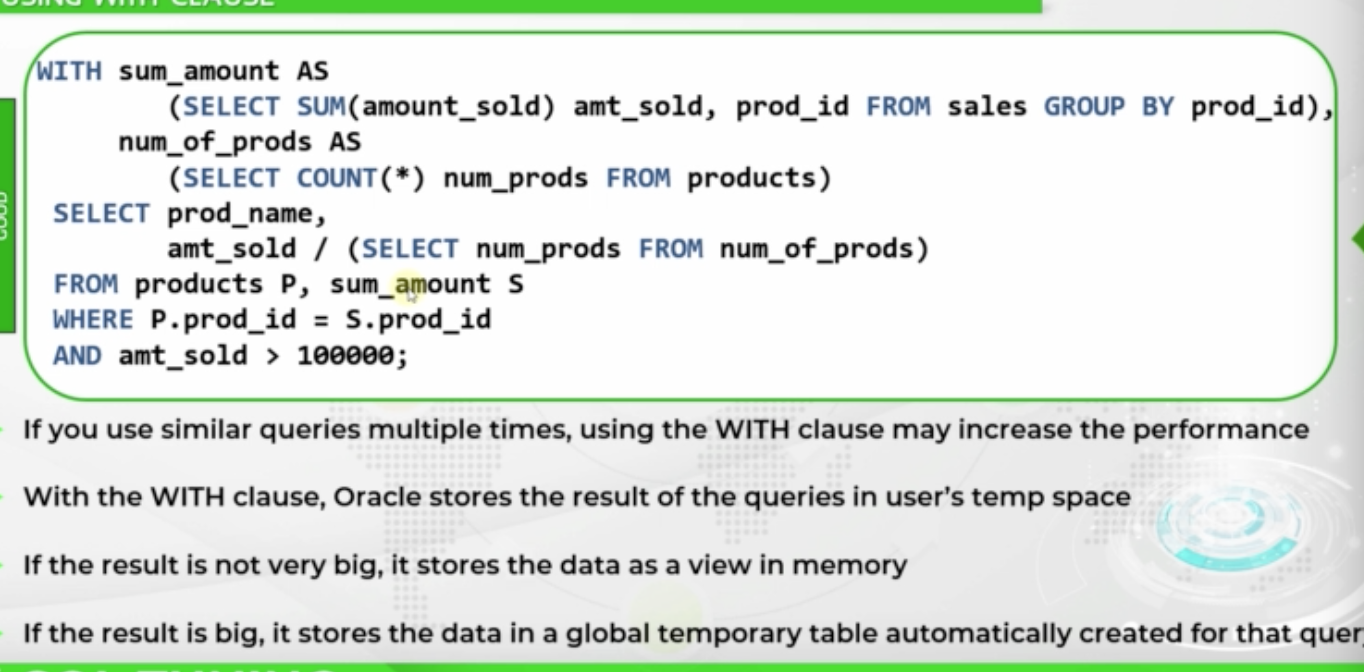

# Using Analytical Functions

# Why Indexing is important?